In [1]:
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import numpy as np
import sys
import healpy as hp
from tqdm import tqdm
import pickle as pl
sys.path.append('../')
import os
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2
from dance.qe import Reconstruct
from dance.utils import slice_alms, bin_power_spectrum,get_n0_iter,get_n0_qe

MPI startup(): FI_PSM3_UUID was not generated, please set it to avoid possible resources ownership conflicts between MPI processes


In [3]:
basedir = '/mnt/sdceph/users/alonappan/DANCE_debug'
datadir = '/mnt/home/alonappan/workspace/dance/data'

In [4]:
fname = os.path.join(datadir,'recon_p.pkl')
if os.path.isfile(fname):
    data = pl.load(open(fname,'rb'))
    cl_pp = data['cl_pp']
    cl_pp_cross = data['cl_pp_cross']
    N0 = data['N0']
else:
    recon_pp = Reconstruct(basedir,2048,6,beta=0.35,lmin_ivf=2,lmax_ivf=4096,qe_key='p_p',lmax_qlm=4096,verbose=1)
    cl_pp = recon_pp.cmb.cl_pp()[:recon_pp.lmax_qlm+1]
    cl_pp_cross = []
    for i in tqdm(range(100)):
        theory = slice_alms(recon_pp.cmb.phi_alm(i),recon_pp.lmax_qlm)
        recon = recon_pp.get_qlm_recon(i,norm=True)
        cl = hp.alm2cl(theory,recon)
        cl_pp_cross.append(cl)
    cl_pp_cross = np.array(cl_pp_cross)
    N0 = []
    for i in tqdm(range(100)):
        N0.append(recon_pp.get_n0(i))
    N0 = np.array(N0)
    data = {'cl_pp':cl_pp,'cl_pp_cross':cl_pp_cross,'N0':N0}
    pl.dump(data,open(fname,'wb'))

In [5]:
L = np.arange(len(cl_pp))
dl = L**2*(L**2+1)/(2*np.pi)
cl_binned = []
for i in tqdm(range(100)):
    B,cb = bin_power_spectrum(800,dl*cl_pp_cross[i],'linear')
    cl_binned.append(cb)
cl_binned = np.array(cl_binned)
cl_binned_mean = np.mean(cl_binned,axis=0)
cl_binned_std = np.std(cl_binned,axis=0)

100%|██████████| 100/100 [00:02<00:00, 45.15it/s]


In [6]:
n02_qe,n02_i = get_n0_qe(2),get_n0_iter(2)
n01_qe,n01_i = get_n0_qe(1),get_n0_iter(1)

Text(0, 0.5, '$\\frac{L^2(L^2+1)}{2\\pi}C_L^{\\phi \\phi}$')

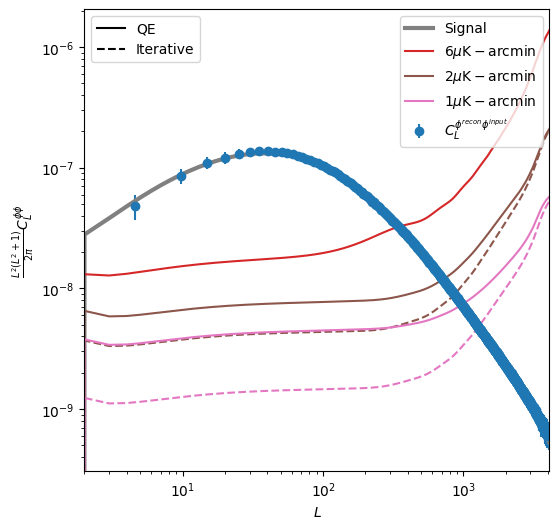

In [7]:
plt.figure(figsize=(6,6))
plt.errorbar(B,cl_binned_mean,yerr=cl_binned_std,fmt='o',label='$C_L^{\phi^{recon}\phi^{input}}$')
plt.loglog(L,dl*cl_pp,label='Signal',lw=3,color='Grey')
plt.loglog(L,dl*N0.mean(axis=0),label='$6\mu \mathrm{K-arcmin}$',color='C3')
plt.loglog(L,dl*n02_qe,label='$2\mu \mathrm{K-arcmin}$' ,color='C5')
plt.loglog(L,dl*n02_i,color='C5',ls='--')
plt.loglog(L,dl*n01_qe,label='$1\mu \mathrm{K-arcmin}$',color='C6')
plt.loglog(L,dl*n01_i,color='C6',ls='--')
plt.xlim(2,4096)
legend1 = plt.legend(loc='upper right')

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='black', linestyle='-', label='QE'),
    Line2D([0], [0], color='black', linestyle='--', label='Iterative')
]
legend2 = plt.legend(handles=legend_elements, loc='upper left')
plt.gca().add_artist(legend1)
plt.xlabel('$L$')
plt.ylabel(r'$\frac{L^2(L^2+1)}{2\pi}C_L^{\phi \phi}$')


In [8]:
fname = os.path.join(datadir,'recon_a.pkl')
if os.path.isfile(fname):
    data = pl.load(open(fname,'rb'))
    cl_aa = data['cl_aa']
    cl_aa_cross = data['cl_aa_cross']
    N0_aa = data['N0']
else:
    recon_aa = Reconstruct(basedir,2048,1,lensed=True,model='aniso',Acb=1e-6,lmin_ivf=2,lmax_ivf=1024,lmax_qlm=1024,qe_key='a_p',verbose=1)
    cl_aa = recon_aa.cmb.cl_aa()[:recon_aa.lmax_qlm+1]
    cl_aa_cross = []
    for i in tqdm(range(100)):
        theory = slice_alms(recon_aa.cmb.alpha_alm(i),recon_aa.lmax_qlm)
        recon = recon_aa.get_qlm_recon(i,norm=True)
        cl = hp.alm2cl(theory,recon)
        cl_aa_cross.append(cl)
    cl_aa_cross = np.array(cl_aa_cross)
    N0_aa = []
    for i in tqdm(range(100)):
        N0_aa.append(recon_aa.get_n0(i))
    N0_aa = np.array(N0_aa)
    data = {'cl_aa':cl_aa,'cl_aa_cross':cl_aa_cross,'N0':N0_aa}
    pl.dump(data,open(fname,'wb'))

In [9]:
cl_aa_binned = []
for i in tqdm(range(100)):
    Ba,cb = bin_power_spectrum(480,cl_aa_cross[i],'linear')
    cl_aa_binned.append(cb)
cl_aa_binned = np.array(cl_aa_binned)
cl_aa_binned_mean = np.mean(cl_aa_binned,axis=0)
cl_aa_binned_std = np.std(cl_aa_binned,axis=0)
N0_a = np.mean(N0_aa,axis=0)

100%|██████████| 100/100 [00:01<00:00, 70.91it/s]


Text(0, 0.5, '$C_L^{\\alpha \\alpha}$')

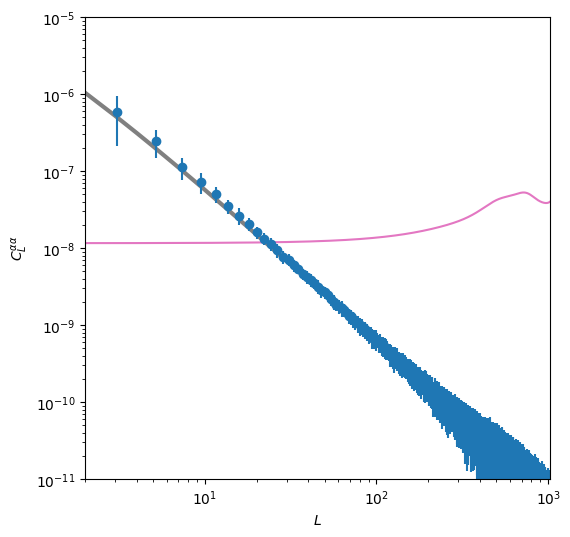

In [11]:
plt.figure(figsize=(6,6))
plt.loglog(cl_aa,label='Signal',lw=3,color='Grey')
plt.errorbar(Ba,cl_aa_binned_mean,yerr=cl_aa_binned_std,fmt='o',label='$C_L^{\alpha^{recon}\alpha^{input}}$')
plt.loglog(N0_a,label='$1\mu \mathrm{K-arcmin}$',color='C6')
plt.xlim(2,1024)
plt.ylim(1e-11,1e-5)
plt.xlabel('$L$')
plt.ylabel(r'$C_L^{\alpha \alpha}$')

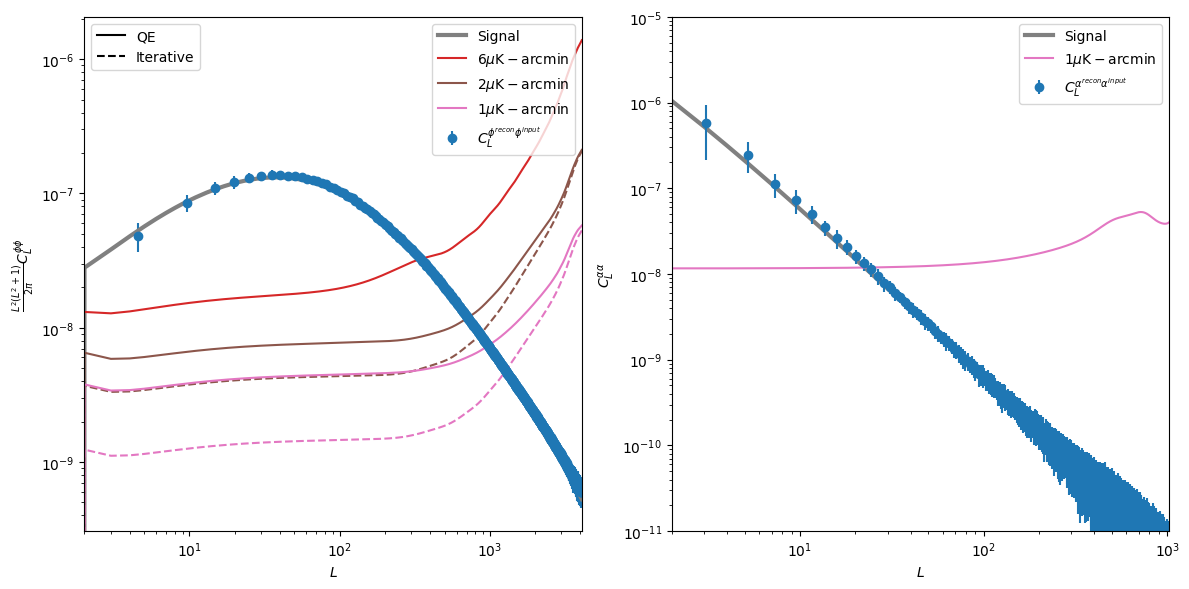

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Two subplots side by side

# Left subplot
ax = axes[0]
ax.errorbar(B, cl_binned_mean, yerr=cl_binned_std, fmt='o', label=r'$C_L^{\phi^{recon}\phi^{input}}$')
ax.loglog(L, dl * cl_pp, label='Signal', lw=3, color='Grey')
ax.loglog(L, dl * N0.mean(axis=0), label=r'$6\mu \mathrm{K-arcmin}$', color='C3')
ax.loglog(L, dl * n02_qe, label=r'$2\mu \mathrm{K-arcmin}$', color='C5')
ax.loglog(L, dl * n02_i, color='C5', ls='--')
ax.loglog(L, dl * n01_qe, label=r'$1\mu \mathrm{K-arcmin}$', color='C6')
ax.loglog(L, dl * n01_i, color='C6', ls='--')
ax.set_xlim(2, 4096)
ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$\frac{L^2(L^2+1)}{2\pi}C_L^{\phi \phi}$')

# First legend
legend1 = ax.legend(loc='upper right')

# Second legend for line styles
legend_elements = [
    Line2D([0], [0], color='black', linestyle='-', label='QE'),
    Line2D([0], [0], color='black', linestyle='--', label='Iterative')
]
legend2 = ax.legend(handles=legend_elements, loc='upper left')
ax.add_artist(legend1)  # Ensure both legends appear

# Right subplot
ax = axes[1]
ax.loglog(cl_aa, label='Signal', lw=3, color='Grey')
ax.errorbar(Ba, cl_aa_binned_mean, yerr=cl_aa_binned_std, fmt='o', label=r'$C_L^{\alpha^{recon}\alpha^{input}}$')
ax.loglog(N0_a, label=r'$1\mu \mathrm{K-arcmin}$', color='C6')
ax.set_xlim(2, 1024)
ax.set_ylim(1e-11, 1e-5)
ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$C_L^{\alpha \alpha}$')
ax.legend(loc='upper right')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()
